## 1. Settings
### 1) Import required libraries

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

### 2) Set hyperparameters

In [2]:
batch_size = 16
learning_rate = 0.0002
num_epoch = 5

## 2. Data

### 1) Download Data

In [3]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)
#MNIST 데이터를 다운로드 받는다.

Processing...
Done!


### 2) Set DataLoader

In [4]:
train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)
#Data Loader를 만들어 준다.

## 3. Model & Optimizer
### 1) Model

In [5]:
class Autoencoder(nn.Module): #Module을 상속한다.
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(28*28, 50) #MNIST는 28 x 28이미지이므로 784를 50의 latent feature로 encode
        self.decoder = nn.Linear(50, 28*28) #50개의 latent feature에서 다시 784개로 decode
        #Linear로도 Autoencoder를 만들 수 있다. 하지만 이미지를 데이터로 사용하는 경우라면, CNN을 사용하는 것이 훨씬 결과가 좋다.
        
        #encoding된 값을 그대로 복원하는 것이 아니라 다른 연산(ex. gray를 RGB로)을 하는 decoder에 넣어줄 수 있다.
        
    def forward(self, x):
        x = x.view(batch_size, -1) #resize
        encoded = self.encoder(x) #encoder에 넣어 준다.
        out = self.decoder(encoded).view(batch_size, 1, 28, 28) #input의 size로 맞춰서 output한다.
        #batch_size, dim, width, height (batch_size, 28 x 28의 1차원 행렬)
        #decoder에 넣어준다.
        
        return out
    
model = Autoencoder() #Model 생성

### 2) Loss func & Optimizer

In [6]:
loss_func = nn.MSELoss() #Autoencoder에서 손실 함수는 주로 L1 이나 L2를 사용한다.
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) #최적화함수
#model.parameters() 로 업데이트해야 할 모든 변수들을 한 번에 가져와 간단히 구현할 수 있다.
#손실에서 lr만큼 움직이고 업데이트 하던 것을 알아서 최적화해서 처리해 준다.

## 4. Train 

In [7]:
for i in range(num_epoch): #num_epoch만큼 반복
    for j, [image, label] in enumerate(train_loader): #DataLoader에서 batch 만큼씩 가져온다.
        x = image
        
        optimizer.zero_grad() #optimiser.step() 으로 업데이트된 그라디언트 값들을 초기화해 줘야 한다.
        output = model.forward(x) #예측 값 #4.0부터는 Variable 없이 그냥 Tensor를 그대로 넣어도 된다.
        loss = loss_func(output, x) #예측한 값과, 정답
        #Autoencoder는 Unsupervised Learning에 많이 쓰인다. Label(정답)이 따로 존재하지 않는다.
        #loss 계산은 encoding, decoding한 이후 나온 output 값과 encoder의 input 값을 비교해 얻을 수 있다(L1, L2 loss를 주로 사용).
        loss.backward() #역전파 해준다.
        optimizer.step() #변수 업데이트

## 5. Check with Train Image

torch.Size([16, 28, 28])


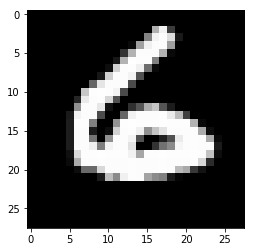

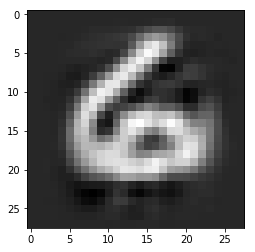

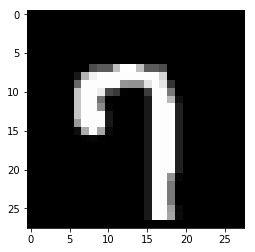

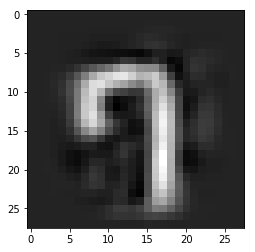

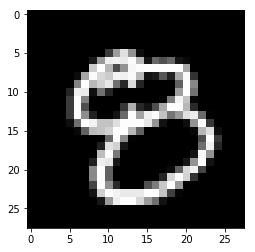

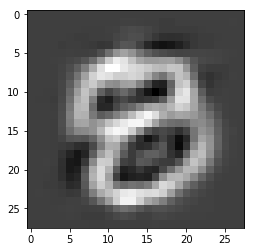

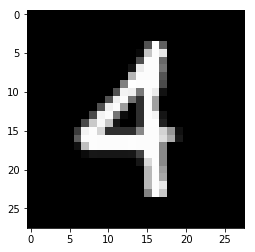

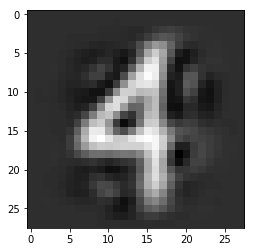

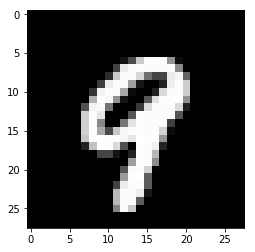

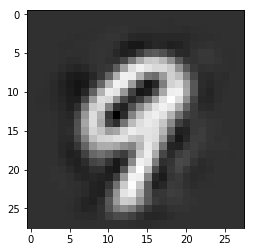

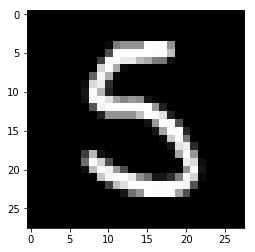

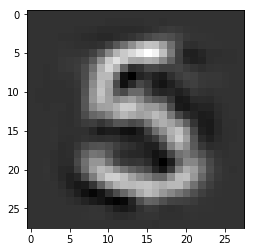

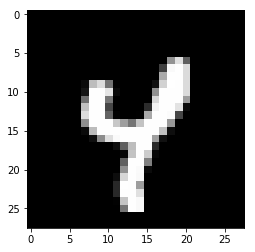

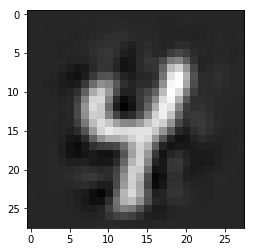

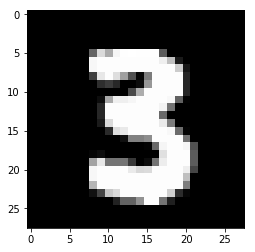

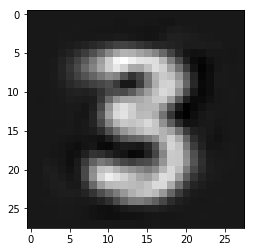

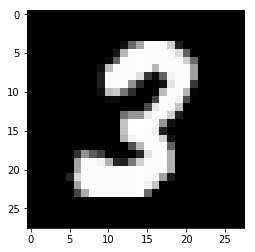

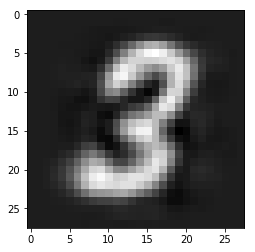

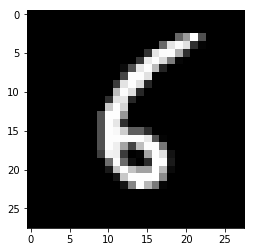

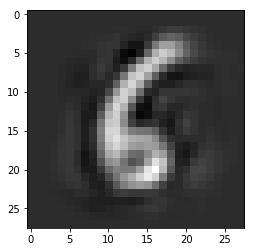

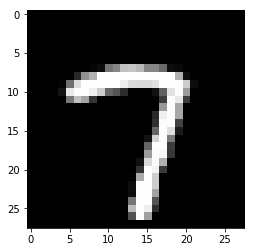

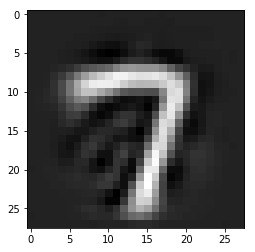

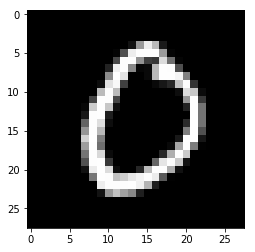

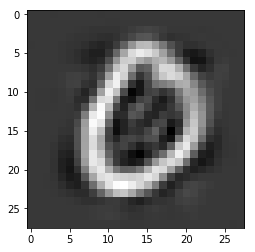

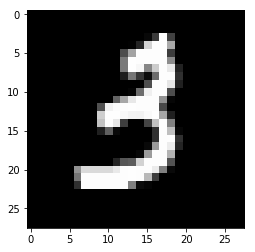

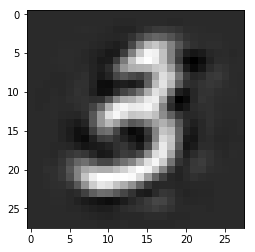

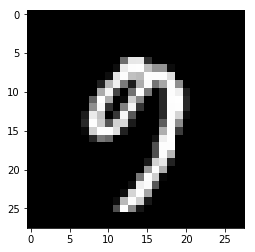

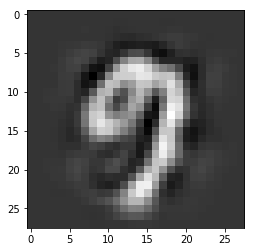

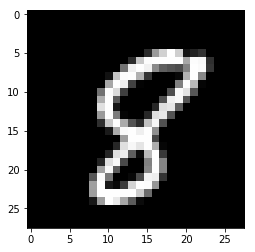

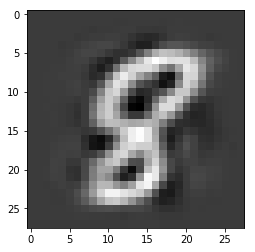

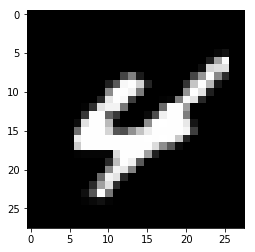

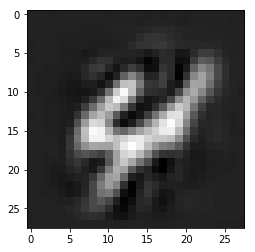

In [8]:
out_img = torch.squeeze(output)
print(out_img.size()) #batch, width, height

for i in range(out_img.size()[0]):
    plt.imshow(torch.squeeze(image[i]).numpy(),cmap='gray')
    plt.show()
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()
    
    
# out_img = torch.squeeze(output)
# print(out_img.size()) #batch, width, height

# for i in range(out_img.size()[0]):
#     plt.imshow(torch.squeeze(image[i]).numpy(),cmap='gray')
#     plt.show()
#     plt.imshow(out_img[i].detach().numpy(),cmap='gray')
#     plt.show()

#CNN 으로 만들면 결과가 나아진다.